In [1]:
%%capture
! pip install arviz==0.11.00
! pip install pymc3==3.10.0

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from pymc3 import math

# Psychophysics

In [3]:
# Load data frame
psychophysics_df = pd.read_csv('https://github.com/embodied-computation-group/CardioceptionPaper/raw/main/data/Del1_merged.txt')

While the data frame has a lot of columns, here we will mainly analyze `Alpha` (the intensity value) and `Decision` (the response made).

For simplicity, in this exercise we will only analyze the data from the first participant (`sub_0019`) during the `Extero` condition.

In [4]:
this_df = psychophysics_df[(psychophysics_df.Modality == 'Extero') & (psychophysics_df.Subject == 'sub_0019')]

Let's take a look at the data. This function will plot the proportion of "Faster" responses depending on the intensity value of the trial stimuli (expressed in BPM). Here, the size of the circle represent the number of trials that were presented for each intensity values.


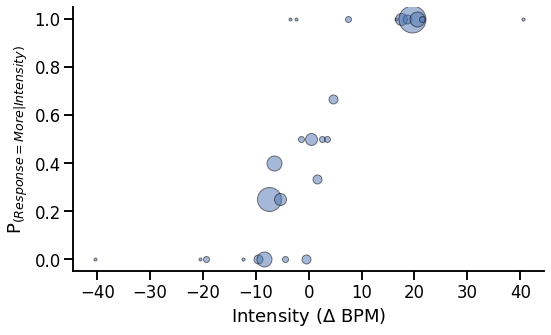

In [5]:
sns.set_context('talk')
fig, axs = plt.subplots(figsize=(8, 5))
for ii, intensity in enumerate(np.sort(this_df.Alpha.unique())):
    resp = sum((this_df.Alpha == intensity) & (this_df.Decision == 'More'))
    total = sum(this_df.Alpha == intensity)
    axs.plot(intensity, resp/total, 'o', alpha=0.5, color='#4c72b0', markeredgecolor='k', markersize=total*3)
plt.ylabel('P$_{(Response = More|Intensity)}$')
plt.xlabel('Intensity ($\Delta$ BPM)')
plt.tight_layout()
sns.despine()

## Exercises

* Create the following figure.

![title](https://github.com/LegrandNico/CognitiveModeling/raw/master/notebooks/data/psychophysics.png)

This figure use the same code as presented above, add a bold blue line representing the most probable psychometric function, and draw 50 grey lines using possible values from the trace generated during model fitting.

The model was defined by:

<img src="https://github.com/LegrandNico/CognitiveModeling/raw/master/notebooks/data/psychophysics2.png" align = 'left' alt="drawing" width="200"/>

$$ r_{i} \sim \mathcal{Binomial}(\theta_{i},n_{i})$$
$$ \theta_{i}(x_{i}, \alpha, \beta) = \frac{1}{2} + \frac{1}{2} * erf(\frac{x_{i} - \alpha}{\beta * \sqrt{2}})$$
$$ \alpha \sim \mathcal{U}(-40.5, 40.5)$$
$$ \beta \sim  |\mathcal{N}(0, 10)|$$

Where $erf$ denotes the [error functions](https://en.wikipedia.org/wiki/Error_function). The error function is available in the `math` submodule of PyMC3 (see [here](https://docs.pymc.io/api/math.html)).

$\phi$ is the cumulative normal function.

## Solutions

We create our own PyMC3 compatible cumulative normal distribution function here.

In [6]:
def cumulative_normal(x, alpha, beta):
    # Cumulative distribution function for the standard normal distribution
    return 0.5 + 0.5 * math.erf((x - alpha) / (beta * np.sqrt(2)))

Create 3 vectors (xij, nij and rij), remove missing data.

In [7]:
x, n, r = np.zeros(163), np.zeros(163), np.zeros(163)

for ii, intensity in enumerate(np.arange(-40.5, 41, 0.5)):
    x[ii] = intensity
    n[ii] = sum(this_df.Alpha == intensity)
    r[ii] = sum((this_df.Alpha == intensity) & (this_df.Decision == "More"))

# remove no responses trials
validmask = n != 0
xij, nij, rij = x[validmask], n[validmask], r[validmask]

Create the model and sample.

In [8]:
with pm.Model():

    alpha = pm.Uniform("alpha", lower=-40.5, upper=40.5)
    beta = pm.HalfNormal("beta", 10)

    thetaij = pm.Deterministic(
        "thetaij", cumulative_normal(xij, alpha, beta)
    )

    rij_ = pm.Binomial("rij", p=thetaij, n=nij, observed=rij)
    trace = pm.sample(
        chains=2, cores=2, tune=2000, draws=2000, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efeca54c910>,
      dtype=object)

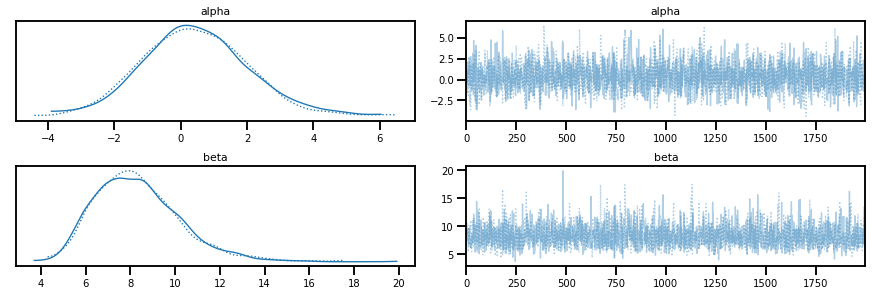

In [9]:
az.plot_trace(trace, var_names=['alpha', 'beta'])

In [10]:
stats = az.summary(trace, ["alpha", "beta"], )
stats

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.446,1.601,-2.564,3.456,0.037,0.029,1917.0,1499.0,2007.0,1684.0,1.0
beta,8.324,1.899,5.117,11.852,0.042,0.030,2084.0,1999.0,2154.0,1816.0,1.0


Extrace the last 25 sample of each chain (here we have 2).

In [11]:
alpha_samples = trace["posterior"]["alpha"].values[:, -25:].flatten()
beta_samples = trace["posterior"]["beta"].values[:, -25:].flatten()

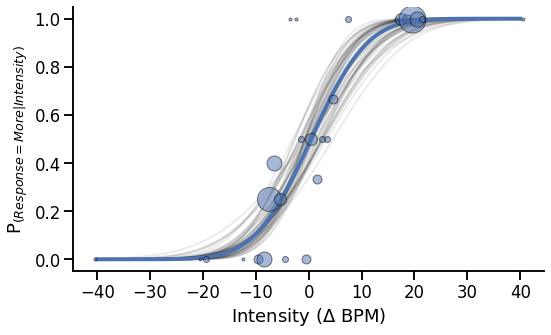

In [12]:
from scipy.stats import norm

sns.set_context('talk')
fig, axs = plt.subplots(figsize=(8, 5))

# Draw some sample from the traces
for a, b in zip(alpha_samples, beta_samples):
  axs.plot(np.linspace(-40, 40, 500), 
          (norm.cdf(np.linspace(-40, 40, 500), loc=a, scale=b)),
          color='k', alpha=.08, linewidth=2)

# Plot psychometric function with average parameters
slope = stats['mean']['beta']
threshold = stats['mean']['alpha']
axs.plot(np.linspace(-40, 40, 500), 
        (norm.cdf(np.linspace(-40, 40, 500), loc=threshold, scale=slope)),
         color='#4c72b0', linewidth=4)

# Draw circles showing response proportions
for ii, intensity in enumerate(np.sort(this_df.Alpha.unique())):
    resp = sum((this_df.Alpha == intensity) & (this_df.Decision == 'More'))
    total = sum(this_df.Alpha == intensity)
    axs.plot(intensity, resp/total, 'o', alpha=0.5, color='#4c72b0', 
             markeredgecolor='k', markersize=total*3)

plt.ylabel('P$_{(Response = More|Intensity)}$')
plt.xlabel('Intensity ($\Delta$ BPM)')
plt.tight_layout()
sns.despine()
plt.savefig('psychophysics.png')

# Hierarchical model

<img src="https://github.com/LegrandNico/CognitiveModeling/raw/master/notebooks/data/hierarchicalPsychophysics.png" align = 'left' alt="drawing" width="300"/>

In [13]:
this_df = psychophysics_df[(psychophysics_df.Modality == 'Extero')]

In [14]:
nsubj = this_df.Subject.nunique()
x_total, n_total, r_total, sub_total = [], [], [], []

for i, sub in enumerate(this_df.Subject.unique()):

  sub_df = this_df[this_df.Subject==sub]

  x, n, r = np.zeros(163), np.zeros(163), np.zeros(163)

  for ii, intensity in enumerate(np.arange(-40.5, 41, 0.5)):
      x[ii] = intensity
      n[ii] = sum(sub_df.Alpha == intensity)
      r[ii] = sum((sub_df.Alpha == intensity) & (sub_df.Decision == "More"))

  # remove no responses trials
  validmask = n != 0
  xij, nij, rij = x[validmask], n[validmask], r[validmask]
  sub_vec = [i] * len(xij)

  x_total.extend(xij)
  n_total.extend(nij)
  r_total.extend(rij)
  sub_total.extend(sub_vec)

In [15]:
with pm.Model():

    mu_alpha = pm.Uniform("mu_alpha", lower=-40.5, upper=40.5)
    sigma_alpha = pm.HalfNormal("sigma_alpha", sigma=100)

    mu_beta = pm.Uniform("mu_beta", lower=0, upper=100)
    sigma_beta = pm.HalfNormal("sigma_beta", sigma=100)

    alpha = pm.Normal("alpha", mu=mu_alpha, sigma=sigma_alpha, shape=nsubj)
    beta = pm.Normal("beta", mu=mu_beta, sigma=sigma_beta, shape=nsubj)

    thetaij = pm.Deterministic(
        "thetaij", cumulative_normal(x_total, alpha[sub_total], beta[sub_total])
    )

    rij_ = pm.Binomial("rij", p=thetaij, n=n_total, observed=r_total)
    trace = pm.sample(
        chains=2, cores=2, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_beta, mu_beta, sigma_alpha, mu_alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 196 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efeca57f390>,
      dtype=object)

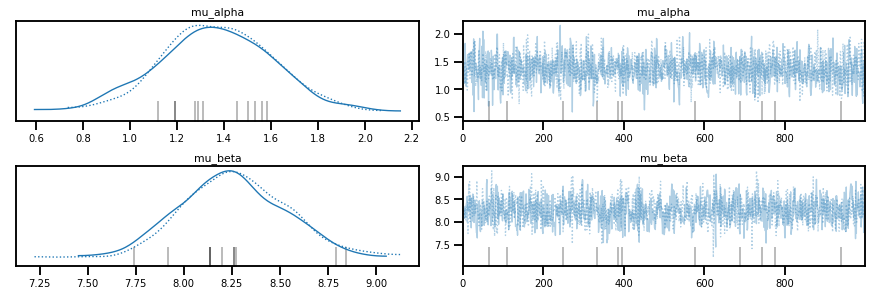

In [16]:
az.plot_trace(trace, var_names=['mu_alpha', 'mu_beta'])